In [1]:
import os
import math
#import graphviz

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

from numpy import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from xgboost import XGBClassifier

from sklearn.impute import KNNImputer

from sklearn.svm import SVC

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

rd_seed = 333

## Načtení dat

In [2]:
path_file = os.sep.join(['created_data', 'matrix.csv'])
matrix = pd.read_csv(path_file, sep=",")

In [3]:
path_file = os.sep.join(['created_data', 'matrix_bak.csv'])
matrix_bak = pd.read_csv(path_file, sep=",")

In [4]:
path_file = os.sep.join(['created_data', 'matrix_mag.csv'])
matrix_mag = pd.read_csv(path_file, sep=",")

## Info o datasetu

In [5]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7736 entries, 0 to 7735
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   studium_id              7736 non-null   int64  
 1   pohlavi_kod             7736 non-null   int64  
 2   je_cech                 7736 non-null   float64
 3   maturita_nastup_rozdil  7736 non-null   float64
 4   dostudoval_uspesne      7736 non-null   int64  
 5   BI-PA1                  7120 non-null   float64
 6   BI-PAI                  7116 non-null   float64
 7   BI-CAO                  6772 non-null   float64
 8   BI-PS1                  7253 non-null   float64
 9   BI-MLO                  6982 non-null   float64
 10  BI-ZMA                  7096 non-null   float64
 11  BI-PA2                  4517 non-null   float64
 12  BI-DBS                  4083 non-null   float64
 13  BI-SAP                  4579 non-null   float64
 14  BI-LIN                  4754 non-null   

In [6]:
matrix_bak.mean()

studium_id                1.009128e+07
pohlavi_kod               1.112978e-01
je_cech                   8.064891e-01
maturita_nastup_rozdil    7.939504e-01
dostudoval_uspesne        2.709411e-01
BI-PA1                    3.043890e+00
BI-PAI                    2.807546e+00
BI-CAO                    2.060617e+00
BI-PS1                    3.128567e+00
BI-MLO                    2.892438e+00
BI-ZMA                    3.154312e+00
BI-PA2                    2.952181e+00
BI-DBS                    2.448322e+00
BI-SAP                    2.377921e+00
BI-LIN                    3.184161e+00
BI-AG1                    2.817040e+00
BI-AAG                    2.662584e+00
BI-ZDM                    2.777810e+00
BI-OSY                    2.682435e+00
BI-PSI                    2.500322e+00
BI-BEZ                    2.500170e+00
BI-PST                    2.299922e+00
BI-DPR                    1.569867e+00
BI-SI1.2                  2.206149e+00
BI-EMP                    1.887801e+00
dtype: float64

## Příprava datasetu

### Nastavení indexu

In [7]:
matrix_bak = matrix_bak.set_index(['studium_id'])

### Odstranění příznaků

In [8]:
matrix_bak = matrix_bak.drop(columns=['BI-AG1', 'BI-DPR'])

### Přidání příznaků

In [9]:
matrix_bak['prumer'] = matrix_bak.loc[:, 'BI-PA1':'BI-EMP'].mean(axis=1)

### Doplnění NaN hodnot

##### Doplnění průměrem daného předmětu

In [10]:
matrix_bak_mean = matrix_bak.copy(deep=True)

courses = ['BI-PA1', 'BI-PAI', 'BI-CAO', 'BI-PS1', 'BI-MLO', 'BI-ZMA',
           'BI-PA2', 'BI-DBS', 'BI-SAP', 'BI-LIN', 
           'BI-AAG', 'BI-ZDM', 'BI-OSY', 'BI-PSI', 'BI-BEZ', 'BI-PST',
           'BI-SI1.2', 'BI-EMP']
means = dict()

for course in courses:
    mean = matrix_bak_mean[course].mean()
    means[course] = mean
    matrix_bak_mean[course].fillna(value=mean, inplace=True)

###### Doplnění nan hodnot u průměru průměrem

In [11]:
prumer_mean = matrix_bak_mean['prumer'].mean()
matrix_bak_mean['prumer'].fillna(value=prumer_mean, inplace=True)

##### Doplnění pomocí KNNImputer

In [12]:
#TODO

## Modelování

### Bakalář všechny pp

#### Rozdělení datasetu

In [13]:
Xdata = matrix_bak_mean.drop(columns='dostudoval_uspesne')
ydata = matrix_bak_mean.dostudoval_uspesne

In [14]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
print("původní data")
display(Xdata.shape)
display(ydata.shape)
print("trénovací data")
display(Xtrain.shape)
display(ytrain.shape)
print("testovací data")
display(Xtest.shape)
display(ytest.shape)

Xtrain_o = Xtrain.copy(deep=True)
Xtest_o = Xtest.copy(deep=True)

Xtrain = Xtrain.fillna(0)
Xtest = Xtest.fillna(0)

původní data


(7736, 22)

(7736,)

trénovací data


(5802, 22)

(5802,)

testovací data


(1934, 22)

(1934,)

#### Funkce pro vybrání vhodných hyperparametrů pomocí křížové validace

In [15]:
def get_best_parameters(param_grid, classifier, xgb=None):
    scores = ['accuracy', 'f1']
    models = []
    for score in scores:
        print('score ' + score + '\n')

        if xgb:
            model = GridSearchCV(classifier(eval_metric='mlogloss', use_label_encoder=False), param_grid, scoring=score)
        else:
            model = GridSearchCV(classifier(), param_grid, scoring=score)
        model.fit(Xtrain, ytrain)

        print('Best hyper-parameters are: ')
        print(model.best_params_)
        print()

        means = model.cv_results_["mean_test_score"]
        stds = model.cv_results_["std_test_score"]
        for mean, std, params in zip(means, stds, model.cv_results_["params"]):
            print("%0.6f (+/-%0.06f) for %r" % (mean, std * 2, params))
        print()
        models.append(model)
    return models

#### Rozhodovací strom

In [16]:
param_grid = [
    {'criterion':['gini','entropy'],
    'max_depth': range(2,5),
    'min_samples_leaf':[10]}
]

In [17]:
dt_acc, dt_f1 = get_best_parameters(param_grid, DecisionTreeClassifier)

score accuracy

Best hyper-parameters are: 
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}

0.956395 (+/-0.011460) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
0.963806 (+/-0.005762) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
0.969322 (+/-0.006395) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}
0.957084 (+/-0.010412) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10}
0.961738 (+/-0.008748) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10}
0.967943 (+/-0.007324) for {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10}

score f1

Best hyper-parameters are: 
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}

0.920266 (+/-0.021642) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
0.935233 (+/-0.010124) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
0.944126 (+/-0.010774) for {'criterion': 'gini', 'max_depth': 4, 'min_

In [18]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt_acc.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt_acc.predict(Xtest))))

print()

print('f1 score (train): {0:.6f}'.format(metrics.f1_score(ytrain, dt_f1.predict(Xtrain))))
print('f1 score (test): {0:.6f}'.format(metrics.f1_score(ytest, dt_f1.predict(Xtest))))

accuracy score (train): 0.970183
accuracy score (test): 0.956050

f1 score (train): 0.946089
f1 score (test): 0.924978


In [19]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':dt_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
21,prumer,0.885667
12,BI-LIN,0.050902
9,BI-PA2,0.022616
18,BI-PST,0.021943
13,BI-AAG,0.014635
5,BI-CAO,0.003753
14,BI-ZDM,0.000352
2,maturita_nastup_rozdil,0.000132
20,BI-EMP,0.000000
19,BI-SI1.2,0.000000


In [20]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':dt_acc.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
21,prumer,0.885667
12,BI-LIN,0.050902
9,BI-PA2,0.022616
18,BI-PST,0.021943
13,BI-AAG,0.014635
5,BI-CAO,0.003753
14,BI-ZDM,0.000352
2,maturita_nastup_rozdil,0.000132
20,BI-EMP,0.000000
19,BI-SI1.2,0.000000


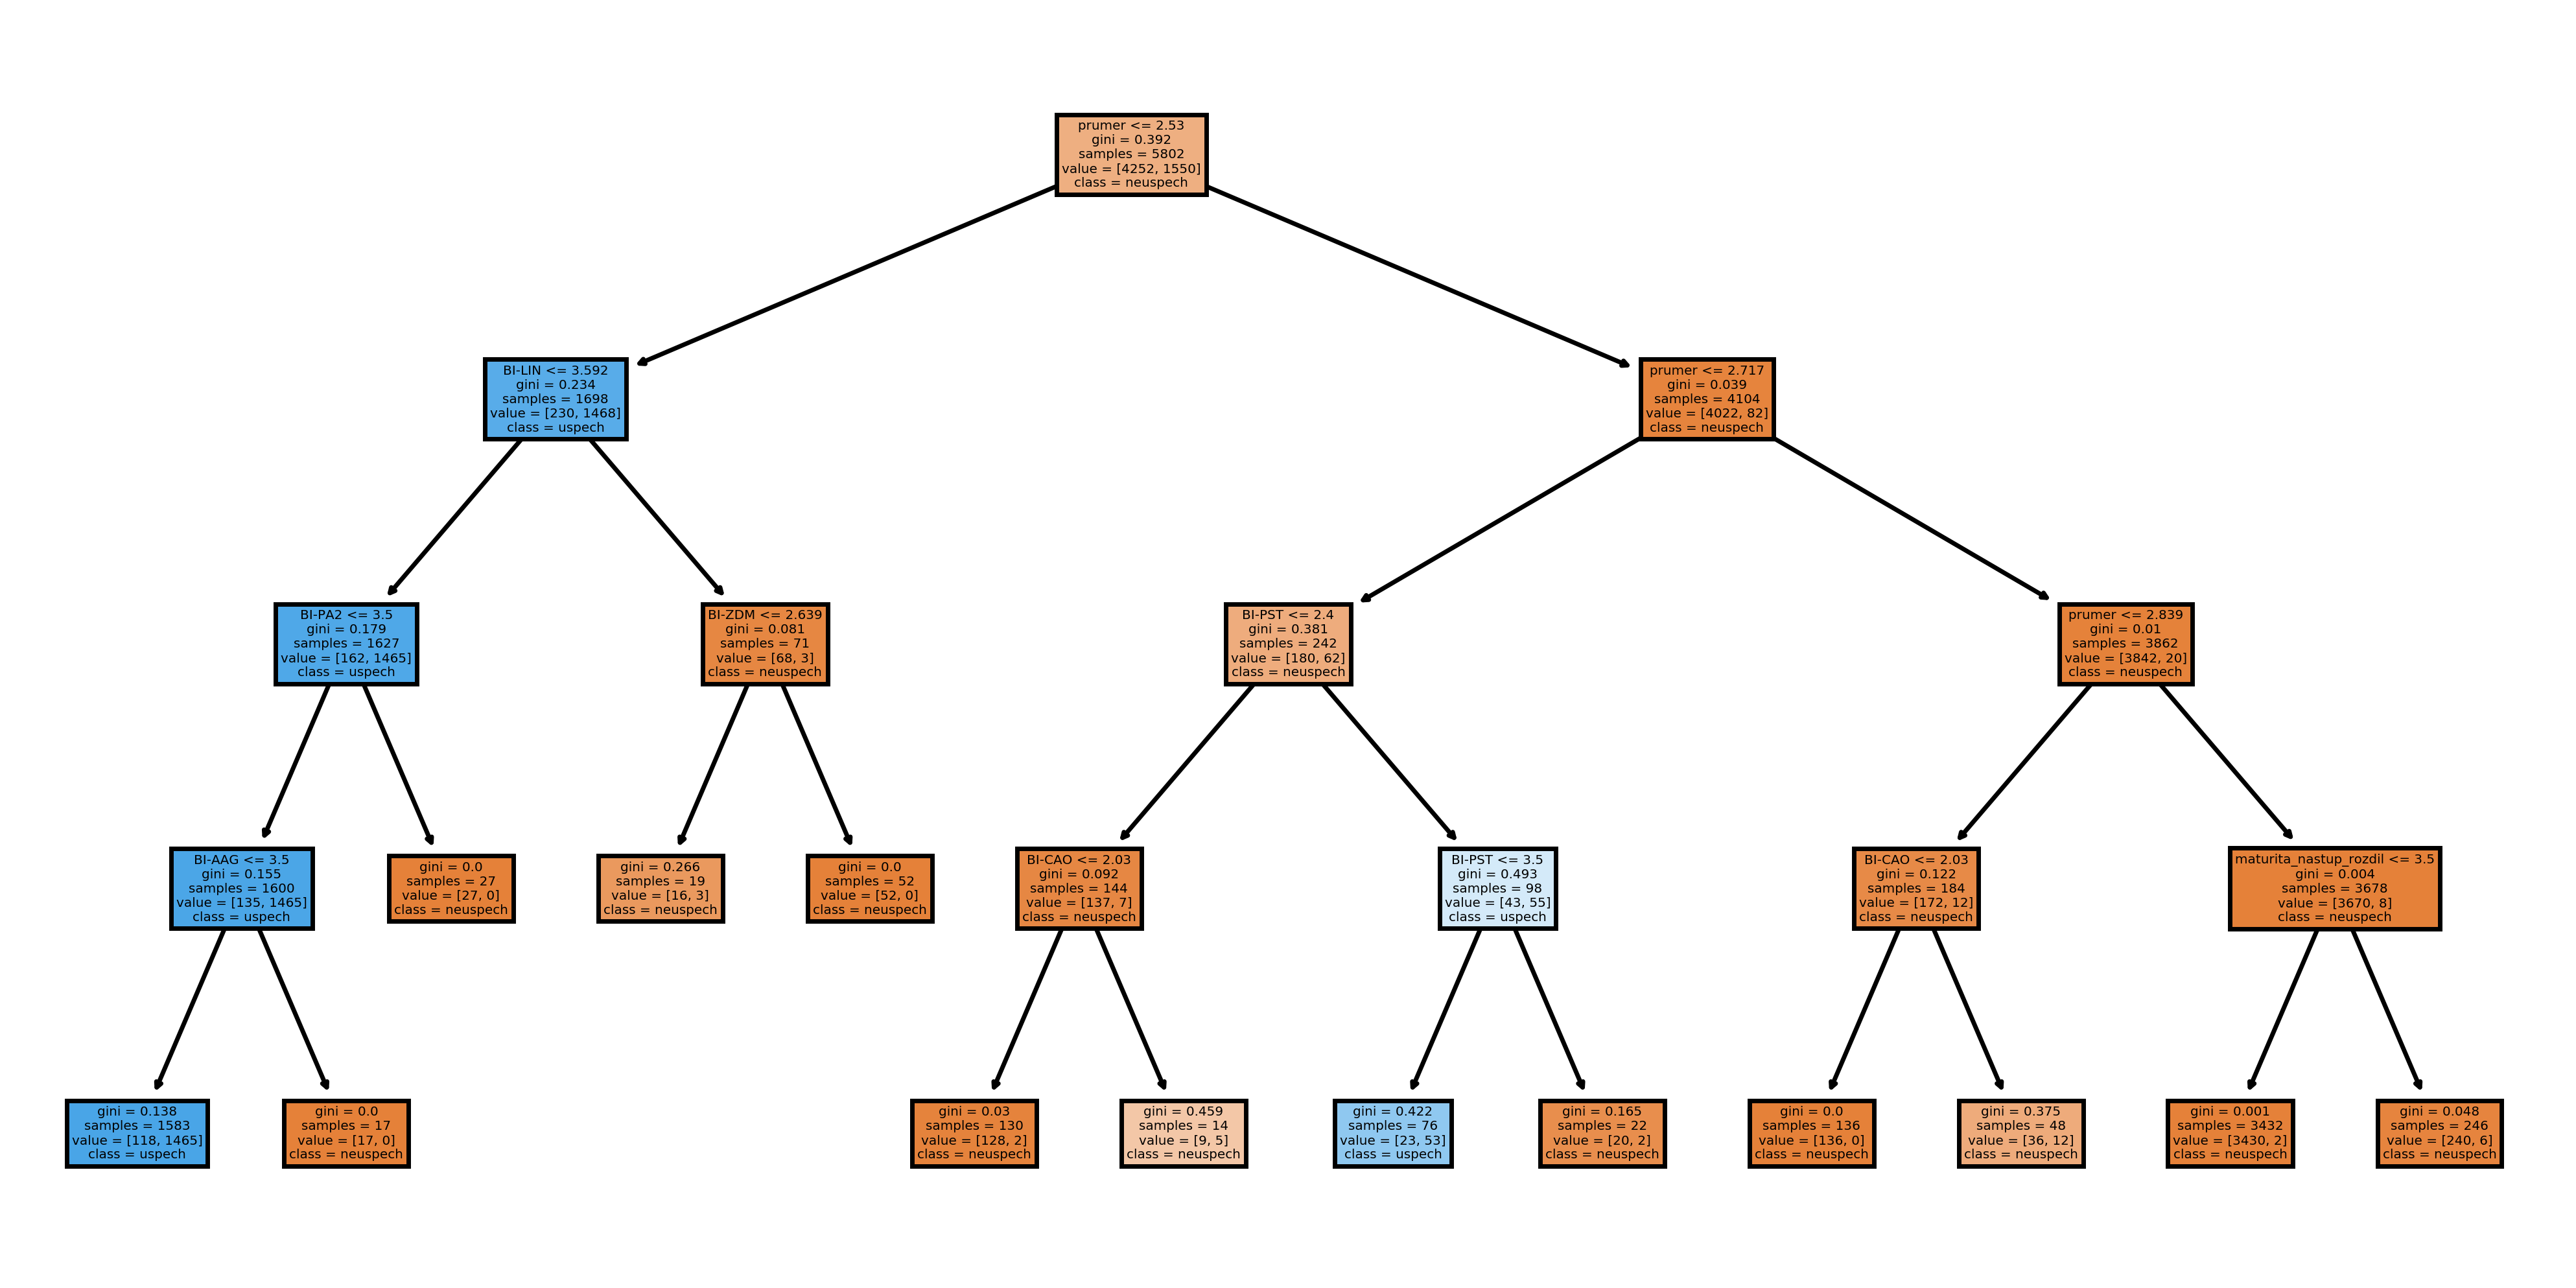

In [21]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=500)
tree.plot_tree(dt_f1.best_estimator_,
               feature_names = Xdata.columns, 
               class_names=['neuspech', 'uspech'],
               filled = True);
fig.savefig('tree_f1.png')

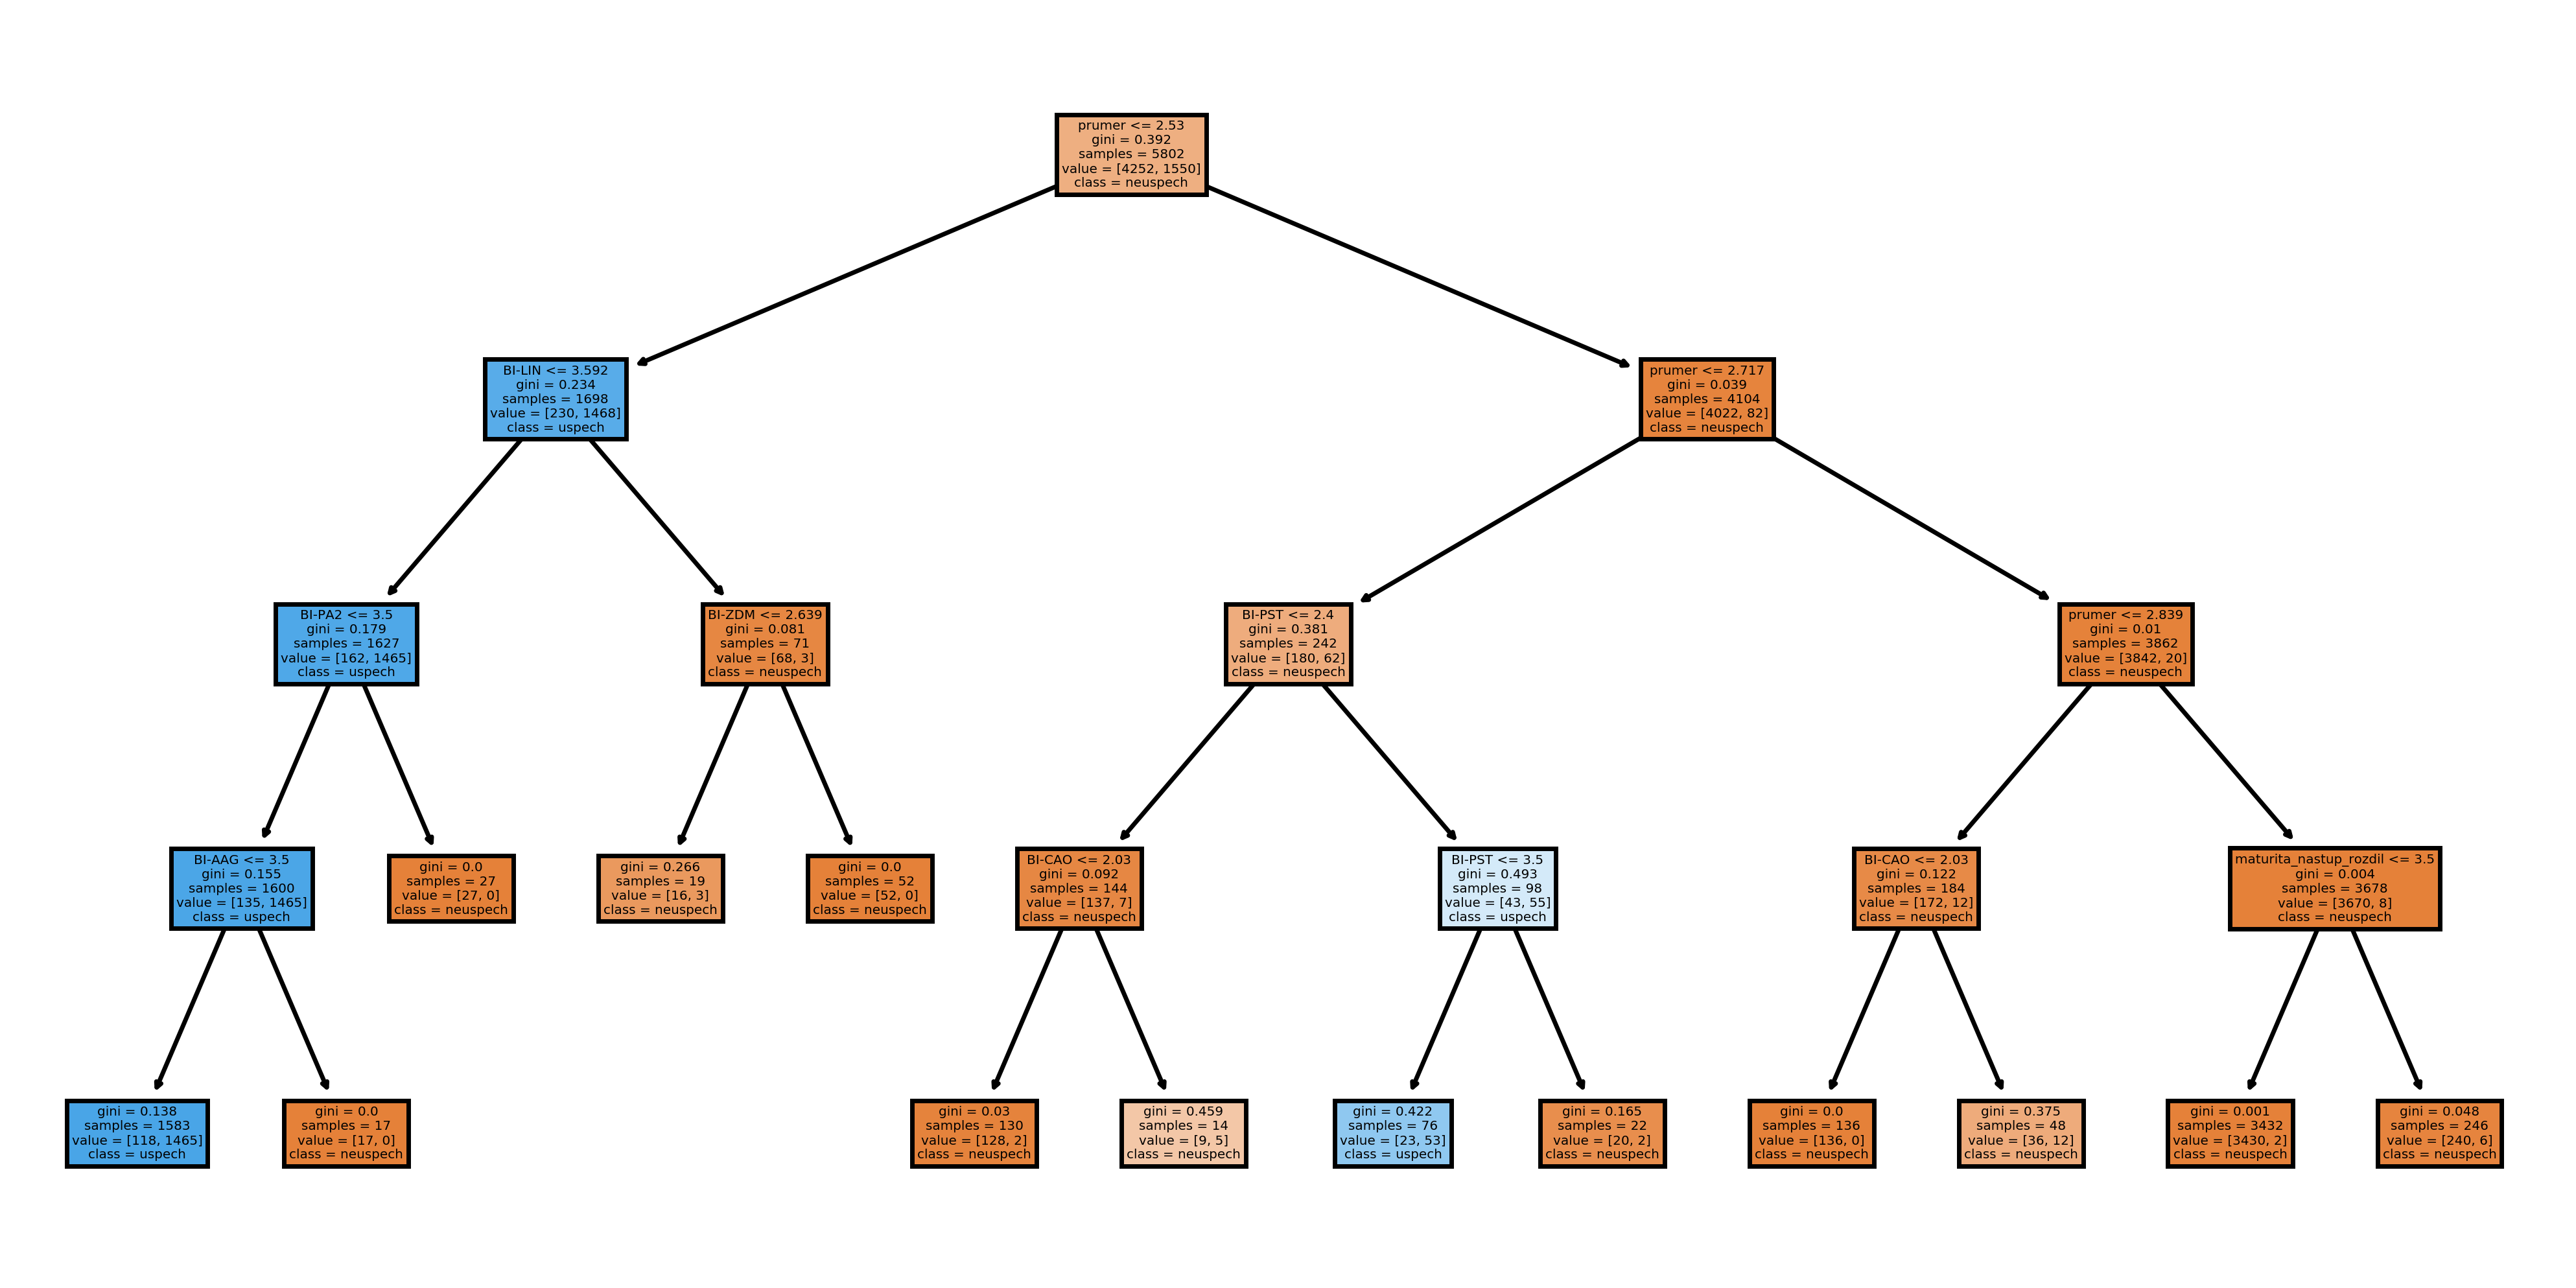

In [22]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=500)
tree.plot_tree(dt_acc.best_estimator_,
               feature_names = Xdata.columns, 
               class_names=['neuspech', 'uspech'],
               filled = True);
fig.savefig('tree_acc.png')

#### Random forest

In [26]:
param_grid_rf = {
    'criterion':['gini','entropy'],
    'n_estimators': range(5, 50, 5),
    'max_depth': range(2, 4),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf':[10]
}

In [27]:
rf_acc, rf_f1 = get_best_parameters(param_grid_rf, RandomForestClassifier)

score accuracy

Best hyper-parameters are: 
{'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 35}

0.949329 (+/-0.012763) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 5}
0.956740 (+/-0.009067) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 10}
0.958118 (+/-0.007443) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 15}
0.957773 (+/-0.007073) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 20}
0.959152 (+/-0.004589) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 25}
0.958291 (+/-0.010074) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30}
0.960531 (+/-0.006301) for {'criterion': 'gini', 'ma

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 15}

0.913243 (+/-0.020208) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 5}
0.925409 (+/-0.015421) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 10}
0.919499 (+/-0.019550) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 15}
0.926865 (+/-0.013433) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 20}
0.922736 (+/-0.017472) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 25}
0.929138 (+/-0.011493) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30}
0.923413 (+/-0.009146) for {'criterion': 'gini', 'max_depth': 2, 

In [28]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, rf_acc.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, rf_acc.predict(Xtest))))

print()

print('f1 score (train): {0:.6f}'.format(metrics.f1_score(ytrain, rf_f1.predict(Xtrain))))
print('f1 score (test): {0:.6f}'.format(metrics.f1_score(ytest, rf_f1.predict(Xtest))))

accuracy score (train): 0.966391
accuracy score (test): 0.955533

f1 score (train): 0.938917
f1 score (test): 0.926222


In [29]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':rf_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
21,prumer,0.227680
12,BI-LIN,0.167449
14,BI-ZDM,0.131214
17,BI-BEZ,0.113103
13,BI-AAG,0.106588
16,BI-PSI,0.096657
9,BI-PA2,0.057235
15,BI-OSY,0.042213
20,BI-EMP,0.028538
3,BI-PA1,0.010480


In [30]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':rf_acc.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
21,prumer,0.277450
12,BI-LIN,0.177212
17,BI-BEZ,0.128091
13,BI-AAG,0.090062
16,BI-PSI,0.058318
18,BI-PST,0.054970
15,BI-OSY,0.049943
14,BI-ZDM,0.049910
9,BI-PA2,0.044803
20,BI-EMP,0.027680


#### SVM

In [31]:
param_grid_svm = {
    'kernel':['linear', 'rbf'],
    'gamma':['auto', 'scale'],
    'C':[100, 10, 1, 0.1]
}
param_comb_svm = ParameterGrid(param_grid_svm)

In [32]:
svc_acc, svc_f1 = get_best_parameters(param_grid_svm, SVC)

score accuracy

Best hyper-parameters are: 
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

0.961221 (+/-0.013026) for {'C': 100, 'gamma': 'auto', 'kernel': 'linear'}
0.957773 (+/-0.008591) for {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
0.961221 (+/-0.013026) for {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
0.961221 (+/-0.011005) for {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
0.961221 (+/-0.012983) for {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}
0.970183 (+/-0.006221) for {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.961221 (+/-0.012983) for {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.969838 (+/-0.004361) for {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.961738 (+/-0.011511) for {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
0.969322 (+/-0.006393) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.961738 (+/-0.011511) for {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.968977 (+/-0.005749) for {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.960876 (+/-0.014150) for {'C': 0.

In [33]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, svc_acc.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, svc_acc.predict(Xtest))))

print()

print('f1 score (train): {0:.6f}'.format(metrics.f1_score(ytrain, svc_f1.predict(Xtrain))))
print('f1 score (test): {0:.6f}'.format(metrics.f1_score(ytest, svc_f1.predict(Xtest))))

accuracy score (train): 0.983626
accuracy score (test): 0.965874

f1 score (train): 0.969889
f1 score (test): 0.941281


#### Adaboost

In [34]:
param_grid_ab = {
    'n_estimators': range(5, 50, 5),
    'learning_rate': np.arange(0.1, 1., 0.1)
}

In [35]:
ab_acc, ab_f1 = get_best_parameters(param_grid_ab, AdaBoostClassifier)

score accuracy

Best hyper-parameters are: 
{'learning_rate': 0.9, 'n_estimators': 45}

0.945192 (+/-0.011751) for {'learning_rate': 0.1, 'n_estimators': 5}
0.952086 (+/-0.010586) for {'learning_rate': 0.1, 'n_estimators': 10}
0.953120 (+/-0.008815) for {'learning_rate': 0.1, 'n_estimators': 15}
0.960014 (+/-0.007762) for {'learning_rate': 0.1, 'n_estimators': 20}
0.967426 (+/-0.008253) for {'learning_rate': 0.1, 'n_estimators': 25}
0.971045 (+/-0.005405) for {'learning_rate': 0.1, 'n_estimators': 30}
0.972424 (+/-0.004742) for {'learning_rate': 0.1, 'n_estimators': 35}
0.972424 (+/-0.004615) for {'learning_rate': 0.1, 'n_estimators': 40}
0.972769 (+/-0.004560) for {'learning_rate': 0.1, 'n_estimators': 45}
0.949328 (+/-0.008883) for {'learning_rate': 0.2, 'n_estimators': 5}
0.957946 (+/-0.009074) for {'learning_rate': 0.2, 'n_estimators': 10}
0.966047 (+/-0.004922) for {'learning_rate': 0.2, 'n_estimators': 15}
0.969322 (+/-0.006751) for {'learning_rate': 0.2, 'n_estimators': 20}
0.97

In [36]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, ab_acc.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, ab_acc.predict(Xtest))))

print()

print('f1 score (train): {0:.6f}'.format(metrics.f1_score(ytrain, ab_f1.predict(Xtrain))))
print('f1 score (test): {0:.6f}'.format(metrics.f1_score(ytest, ab_f1.predict(Xtest))))

accuracy score (train): 0.978800
accuracy score (test): 0.968976

f1 score (train): 0.961260
f1 score (test): 0.946619


In [37]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':ab_f1.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
21,prumer,0.311111
18,BI-PST,0.111111
19,BI-SI1.2,0.066667
16,BI-PSI,0.066667
14,BI-ZDM,0.066667
17,BI-BEZ,0.044444
7,BI-MLO,0.044444
8,BI-ZMA,0.044444
9,BI-PA2,0.044444
15,BI-OSY,0.044444


In [38]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':ab_acc.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
21,prumer,0.311111
18,BI-PST,0.111111
19,BI-SI1.2,0.066667
16,BI-PSI,0.066667
14,BI-ZDM,0.066667
17,BI-BEZ,0.044444
7,BI-MLO,0.044444
8,BI-ZMA,0.044444
9,BI-PA2,0.044444
15,BI-OSY,0.044444


#### Xgboost

In [39]:
param_grid = {
    'eta': np.arange(0.1, 1., 0.1),
    'max_depth': range(3, 8)
}
param_comb = ParameterGrid(param_grid)

In [40]:
xgb_acc, xgb_f1 = get_best_parameters(param_grid, XGBClassifier, True)

score accuracy

Best hyper-parameters are: 
{'eta': 0.2, 'max_depth': 3}

0.975699 (+/-0.003978) for {'eta': 0.1, 'max_depth': 3}
0.976560 (+/-0.004128) for {'eta': 0.1, 'max_depth': 4}
0.976733 (+/-0.004743) for {'eta': 0.1, 'max_depth': 5}
0.976043 (+/-0.004669) for {'eta': 0.1, 'max_depth': 6}
0.975871 (+/-0.006624) for {'eta': 0.1, 'max_depth': 7}
0.976906 (+/-0.007490) for {'eta': 0.2, 'max_depth': 3}
0.974837 (+/-0.006296) for {'eta': 0.2, 'max_depth': 4}
0.974665 (+/-0.006212) for {'eta': 0.2, 'max_depth': 5}
0.973802 (+/-0.007906) for {'eta': 0.2, 'max_depth': 6}
0.973285 (+/-0.006716) for {'eta': 0.2, 'max_depth': 7}
0.975527 (+/-0.007588) for {'eta': 0.30000000000000004, 'max_depth': 3}
0.975009 (+/-0.005758) for {'eta': 0.30000000000000004, 'max_depth': 4}
0.973630 (+/-0.005720) for {'eta': 0.30000000000000004, 'max_depth': 5}
0.972596 (+/-0.006096) for {'eta': 0.30000000000000004, 'max_depth': 6}
0.972251 (+/-0.008684) for {'eta': 0.30000000000000004, 'max_depth': 7}
0.9751

In [41]:
print('f1 score XGBoost (train): {0:.6f}'.format(metrics.f1_score(ytrain, xgb_f1.predict(Xtrain))))
print('f1 score XGBoost (val): {0:.6f}'.format(metrics.f1_score(ytest, xgb_f1.predict(Xtest))))

print('accuracy score XGBoost (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, xgb_acc.predict(Xtrain))))
print('accuracy score XGBoost (val): {0:.6f}'.format(metrics.accuracy_score(ytest, xgb_acc.predict(Xtest))))

f1 score XGBoost (train): 0.967254
f1 score XGBoost (val): 0.948399
accuracy score XGBoost (train): 0.982075
accuracy score XGBoost (val): 0.970010


In [42]:
feat_imp = pd.Series(xgb_f1.best_estimator_.get_booster().get_fscore()).sort_values(ascending=False)

In [43]:
feat_imp

prumer                    83.0
BI-PST                    52.0
BI-AAG                    39.0
maturita_nastup_rozdil    34.0
BI-ZDM                    30.0
BI-PA2                    30.0
BI-BEZ                    29.0
BI-OSY                    27.0
BI-PSI                    22.0
BI-ZMA                    20.0
BI-PA1                    19.0
BI-LIN                    18.0
BI-PS1                    18.0
BI-PAI                    16.0
BI-EMP                    16.0
BI-SI1.2                  15.0
BI-MLO                    14.0
BI-DBS                    10.0
BI-CAO                     9.0
BI-SAP                     9.0
je_cech                    3.0
pohlavi_kod                2.0
dtype: float64

In [44]:
feat_imp = pd.Series(xgb_acc.best_estimator_.get_booster().get_fscore()).sort_values(ascending=False)

In [45]:
feat_imp

prumer                    83.0
BI-PST                    52.0
BI-AAG                    39.0
maturita_nastup_rozdil    34.0
BI-ZDM                    30.0
BI-PA2                    30.0
BI-BEZ                    29.0
BI-OSY                    27.0
BI-PSI                    22.0
BI-ZMA                    20.0
BI-PA1                    19.0
BI-LIN                    18.0
BI-PS1                    18.0
BI-PAI                    16.0
BI-EMP                    16.0
BI-SI1.2                  15.0
BI-MLO                    14.0
BI-DBS                    10.0
BI-CAO                     9.0
BI-SAP                     9.0
je_cech                    3.0
pohlavi_kod                2.0
dtype: float64

#### Baseline

In [46]:
def baseline(dataset):
    return pd.Series(index=dataset.index, data=np.zeros(len(dataset)))

In [47]:
print('f1 score baseline (train): {0:.6f}'.format(metrics.f1_score(ytrain, baseline(Xtrain))))
print('f1 score baseline (test): {0:.6f}'.format(metrics.f1_score(ytest, baseline(Xtest))))

print('accuracy score baseline (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, baseline(Xtrain))))
print('accuracy score baseline (test): {0:.6f}'.format(metrics.accuracy_score(ytest, baseline(Xtest))))

f1 score baseline (train): 0.000000
f1 score baseline (test): 0.000000
accuracy score baseline (train): 0.732851
accuracy score baseline (test): 0.717684


### Testování po semestrech

In [48]:
results_f1 = pd.DataFrame(columns=['dt', 'rf', 'svm', 'ab', 'xgb', 'bl'], index=[0, 1, 2, 3, 4, 5, 6, 7])
results_acc = pd.DataFrame(columns=['dt', 'rf', 'svm', 'ab', 'xgb', 'bl'], index=[0, 1, 2, 3, 4, 5, 6, 7])

#### Pouze nepředmětové příznaky

In [61]:
Xtest_0 = Xtest.copy(deep=True)

courses = ['BI-PA1', 'BI-PAI', 'BI-CAO', 'BI-PS1', 'BI-MLO', 'BI-ZMA',
           'BI-PA2', 'BI-DBS', 'BI-SAP', 'BI-LIN', 
           'BI-AAG', 'BI-ZDM', 
           'BI-OSY', 'BI-PSI', 'BI-BEZ', 
           'BI-PST',
           'BI-SI1.2', 'BI-EMP']
for course in courses:
    Xtest_0.loc[:, course] = means[course]
Xtest_0.loc[:, 'prumer'] = prumer_mean

#### 1. semestr

In [75]:
Xtest_1 = Xtest.copy(deep=True)

courses = ['BI-PA2', 'BI-DBS', 'BI-SAP', 'BI-LIN', 
           'BI-AAG', 'BI-ZDM', 
           'BI-OSY', 'BI-PSI', 'BI-BEZ', 
           'BI-PST',
           'BI-SI1.2', 'BI-EMP']
for course in courses:
    Xtest_1.loc[:, course] = means[course]
Xtest_1['prumer'] = matrix_bak.loc[:, 'BI-PA1':'BI-ZMA'].mean(axis=1)
Xtest_1['prumer'].fillna(prumer_mean, inplace=True)

#### První dva semestry

In [78]:
Xtest_2 = Xtest.copy(deep=True)

courses = ['BI-AAG', 'BI-ZDM', 
           'BI-OSY', 'BI-PSI', 'BI-BEZ', 
           'BI-PST',
           'BI-SI1.2', 'BI-EMP']
for course in courses:
    Xtest_2.loc[:, course] = means[course]
Xtest_2['prumer'] = matrix_bak.loc[:, 'BI-PA1':'BI-LIN'].mean(axis=1)
Xtest_2['prumer'].fillna(prumer_mean, inplace=True)

#### První tři semestry

In [79]:
Xtest_3 = Xtest.copy(deep=True)

courses = ['BI-OSY', 'BI-PSI', 'BI-BEZ', 
           'BI-PST', 
           'BI-SI1.2', 'BI-EMP']
for course in courses:
    Xtest_3.loc[:, course] = means[course]
Xtest_3['prumer'] = matrix_bak.loc[:, 'BI-PA1':'BI-ZDM'].mean(axis=1)
Xtest_3['prumer'].fillna(prumer_mean, inplace=True)

#### První čtyři semestry 

In [80]:
Xtest_4 = Xtest.copy(deep=True)

courses = ['BI-PST', 
           'BI-SI1.2', 'BI-EMP']
for course in courses:
    Xtest_4.loc[:, course] = means[course]
Xtest_4['prumer'] = matrix_bak.loc[:, 'BI-PA1':'BI-BEZ'].mean(axis=1)
Xtest_4['prumer'].fillna(prumer_mean, inplace=True)

#### Prvních pět semestrů

In [81]:
Xtest_5 = Xtest.copy(deep=True)

courses = ['BI-SI1.2', 'BI-EMP']
for course in courses:
    Xtest_5.loc[:, course] = means[course]
Xtest_5['prumer'] = matrix_bak.loc[:, 'BI-PA1':'BI-PST'].mean(axis=1)
Xtest_5['prumer'].fillna(prumer_mean, inplace=True)

#### Všechny semestry bez SI1.2 a EMP

In [82]:
Xtest_6 = Xtest.copy(deep=True)

courses = ['BI-SI1.2', 'BI-EMP']
for course in courses:
    Xtest_6.loc[:, course] = means[course]
Xtest_6['prumer'] = matrix_bak.loc[:, 'BI-PA1':'BI-PST'].mean(axis=1)
Xtest_6['prumer'].fillna(prumer_mean, inplace=True)

### Výsledky

In [83]:
x_test = {0:Xtest_0, 1:Xtest_1, 2:Xtest_2, 3:Xtest_3, 4:Xtest_4, 5:Xtest_5, 6:Xtest_6, 7:Xtest}
for i in range(0, 8):
    results_f1.loc[i, 'dt'] = round(metrics.f1_score(ytest, dt_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'rf'] = round(metrics.f1_score(ytest, rf_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'svm'] = round(metrics.f1_score(ytest, svc_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'ab'] = round(metrics.f1_score(ytest, ab_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'xgb'] = round(metrics.f1_score(ytest, xgb_f1.predict(x_test[i])), 3)
    results_f1.loc[i, 'bl'] = round(metrics.f1_score(ytest, baseline(x_test[i])), 3)
    
    results_acc.loc[i, 'dt'] = round(metrics.accuracy_score(ytest, dt_acc.predict(x_test[i])), 3)
    results_acc.loc[i, 'rf'] = round(metrics.accuracy_score(ytest, rf_acc.predict(x_test[i])), 3)
    results_acc.loc[i, 'svm'] = round(metrics.accuracy_score(ytest, svc_acc.predict(x_test[i])), 3)
    results_acc.loc[i, 'ab'] = round(metrics.accuracy_score(ytest, ab_acc.predict(x_test[i])), 3)
    results_acc.loc[i, 'xgb'] = round(metrics.accuracy_score(ytest, xgb_acc.predict(x_test[i])), 3)
    results_acc.loc[i, 'bl'] = round(metrics.accuracy_score(ytest, baseline(x_test[i])), 3)

#### Modely s F1 score

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


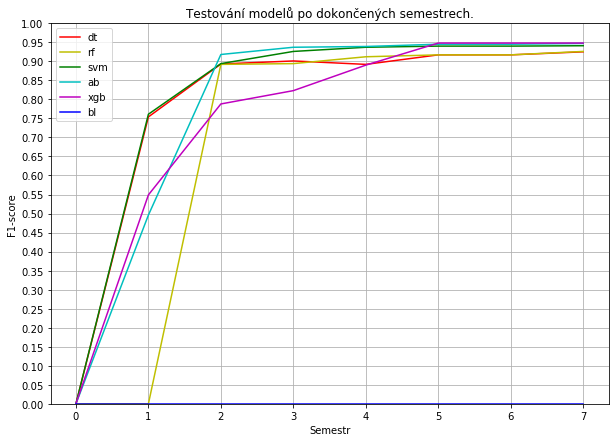

In [84]:
plt.figure(figsize=(10,7))
plt.grid(True)

xdt = results_f1['dt'].index
ydt = results_f1['dt'].values

xrf = results_f1['rf'].index
yrf = results_f1['rf'].values

xsvm = results_f1['svm'].index
ysvm = results_f1['svm'].values

xab = results_f1['ab'].index
yab = results_f1['ab'].values

xxgb = results_f1['xgb'].index
yxgb = results_f1['xgb'].values

xbl = results_f1['bl'].index
ybl = results_f1['bl'].values

y_values = np.arange(0.0, 1.05, 0.05)

plt.plot(xdt, ydt, color='r', label='dt')
plt.plot(xrf, yrf, color='y', label='rf')
plt.plot(xsvm, ysvm, color='g', label='svm')
plt.plot(xab, yab, color='c', label='ab')
plt.plot(xxgb, yxgb, color='m', label='xgb')
plt.plot(xbl, ybl, color='b', label='bl')

plt.title('Testování modelů po dokončených semestrech.')

plt.yticks(y_values)
plt.xlabel('Semestr')
plt.ylabel('F1-score')

plt.legend()

plt.ylim(ymin=0)
plt.ylim(ymax=1)

plt.show()

In [85]:
results_f1

,dt,rf,svm,ab,xgb,bl
0,0,0,0,0,0,0
1,0.754,0,0.761,0.496,0.549,0
2,0.893,0.892,0.894,0.918,0.788,0
3,0.901,0.894,0.926,0.937,0.823,0
4,0.892,0.912,0.937,0.939,0.89,0
5,0.917,0.917,0.94,0.945,0.948,0
6,0.917,0.917,0.94,0.945,0.948,0
7,0.925,0.926,0.941,0.947,0.948,0


#### Modely s accuracy

In [86]:
results_acc

,dt,rf,svm,ab,xgb,bl
0,0.718,0.718,0.718,0.718,0.718,0.718
1,0.828,0.718,0.83,0.794,0.792,0.718
2,0.938,0.925,0.936,0.951,0.891,0.718
3,0.944,0.941,0.957,0.963,0.908,0.718
4,0.94,0.938,0.963,0.965,0.94,0.718
5,0.952,0.948,0.965,0.968,0.97,0.718
6,0.952,0.948,0.965,0.968,0.97,0.718
7,0.956,0.956,0.966,0.969,0.97,0.718
